In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import os, math
 

/var/folders/gg/gm8xvt3d6nq5bgsl60gj3q_80000gn/T/ipykernel_67885/1682386490.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# def plot(algos, regrets, cumsum=False, filename=None, figshow=True, legendloc='bottom left', tick_spacing=200, test_freq=10):
#     assert len(algos) == len(regrets)
#     num_algos = len(algos)
    
#     # Get color range
#     cmap = plt.cm.get_cmap('jet')
#     colors = cmap(np.arange(cmap.N))
#     cinv = cmap.N / (1. * num_algos) 
    
    
#     if cumsum:
#         regrets_ = []
#         for r in regrets:
#             regrets_.append(r.cumsum(axis=1))
#         regrets = regrets_
    
#     # Compute mu and std 
#     mus = []
#     stds = []
#     for r in regrets:
#         mu = np.mean(r,axis=0)
#         std = np.std(r,axis=0) / math.sqrt(r.shape[0])
#         mus.append(mu)
#         stds.append(std) 
        
#     # Plot 
#     T = regrets[0].shape[1]
#     fig = plt.figure(figsize=(5,4))
#     dom = np.arange(T)

#     for i in range(num_algos):
#         color = colors[int( (i + 0.5) * cinv)] 
#         plt.plot(dom, mus[i], label=algos[i], color=color) 
#         plt.fill_between(dom, mus[i] + 1.96 * stds[i],\
#                          mus[i] - 1.96 * stds[i], alpha=0.2, color=color)

#     plt.xlim([0,T])
#     plt.rc('grid', linestyle='--', color='black', alpha=0.2)
#     plt.grid('on')
    
#     if legendloc:
#         plt.legend(loc = legendloc, prop={'size': 11}) 
#     else:
#         plt.legend(prop={'size':11})


#     dom = np.arange(0, T, tick_spacing)
#     # print('T = {}'.format(T))
#     plt.xticks(dom, dom*test_freq)
#     plt.xlabel('Number of samples',fontsize=12)
#     plt.ylabel('Sub-optimality',fontsize=12)

#     if filename:
#         if not os.path.exists('fig'):
#             os.makedirs('fig')
#         fig.savefig(os.path.join('fig', filename), dpi=500, bbox_inches='tight')
    
#     if not figshow:
#         plt.close(fig)
#         plt.clf()

In [3]:
# num_train_sepsis_pat_win = 20
# num_test_pat_septic_win = 5
num_train_sepsis_pat_win = 1000
num_test_pat_septic_win = 250
num_steps = 100
layer_sizes = [100,100]
layer_n = True
buffer_s = -1
batch_size = 32
lr = 1e-3
beta = 0.1
lambd0 = 0.1
lambd = 1e-4
# algo_group = 'approx-neural_cp'

num_actions=2
context_dim = 13
data_type = 'sepsis'
eps= 0.1
policy_prefix = f'eps-greedy{eps}'
noise_std = 0.01
test_freq=10
data_prefix = '{}_d={}_a={}_pi={}_std={}_testfreq={}'.format(data_type, context_dim, num_actions, policy_prefix, noise_std, test_freq)
# res_dir = os.path.join(f'../neuralcb_results/trainwins_{num_train_sepsis_pat_win}_testwins_{num_test_pat_septic_win}', data_prefix) 





# res_dir = os.path.join('results', data_prefix) 
sim = 0

res_dir = os.path.join(f'../neuralcb_results/sim{sim}/trainwins_{num_train_sepsis_pat_win}_testwins_{num_test_pat_septic_win}/', data_prefix) 
# B=10
# B=25

In [4]:
# import pandas as pd
# ApproxNeuraLCB_cp =  'ApproxNeuraLCB_cp'
# algo_prefix = f'{ApproxNeuraLCB_cp}-gridsearch_epochs={num_steps}_m={min(layer_sizes)}_layern={layer_n}_buffer={buffer_s}_bs={batch_size}_lr={lr}_beta={beta}_lambda={lambd}_lambda0={lambd0}.npz' 
# sepsis_path_cp = os.path.join(res_dir, algo_prefix)   
# ApproxNeuraLCB_cp_data = np.load(sepsis_path_cp)
# for key in ApproxNeuraLCB_cp_data.keys():
#     print(f"Key: {key}, Shape: {ApproxNeuraLCB_cp_data[key].shape}, Data Type: {ApproxNeuraLCB_cp_data[key].dtype}")
# # Flatten the arrays and create a DataFrame
# ApproxNeuraLCB_cp_df = pd.DataFrame({
#     'regrets': ApproxNeuraLCB_cp_data['regrets'].flatten(),
#     'act_errs': ApproxNeuraLCB_cp_data['errs'].flatten(),  # Renaming 'errs' to 'act_errs'
# })

# # ApproxNeuraLCB_cp_df = pd.DataFrame({key: ApproxNeuraLCB_cp_data[key] for key in ApproxNeuraLCB_cp_data.keys()})
# if 'errs' in ApproxNeuraLCB_cp_df.columns:
#     ApproxNeuraLCB_cp_df.rename(columns={'errs': 'act_errs'}, inplace=True)

# ApproxNeuraLCB_cp_df['train_size'] =  np.arange(1, 16000, 10)
# algo_prefix_csv = f'{ApproxNeuraLCB_cp}-gridsearch_epochs={num_steps}_m={min(layer_sizes)}_layern={layer_n}_buffer={buffer_s}_bs={batch_size}_lr={lr}_beta={beta}_lambda={lambd}_lambda0={lambd0}.csv' 
# ApproxNeuraLCB_cp_df.to_csv(os.path.join(res_dir, algo_prefix_csv), index=False) 

In [5]:
experts = ['ApproxNeuralLinLCBJointModel','ApproxNeuralLinLCBJointModel_cp']
for algo_group in experts:
    print(algo_group.split('_'))

['ApproxNeuralLinLCBJointModel']
['ApproxNeuralLinLCBJointModel', 'cp']


Regrets_cp shape: (1600,)
Regrets_cp shape: (1600,)


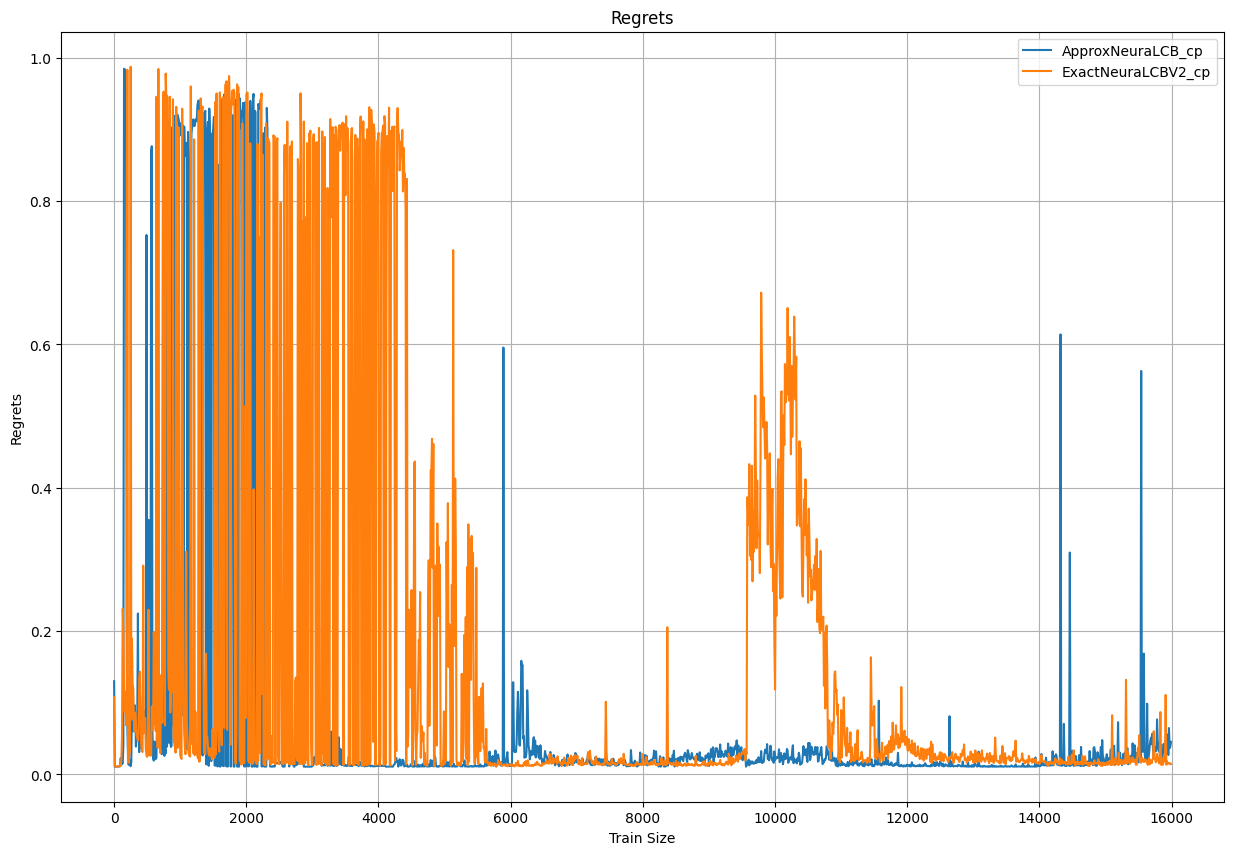

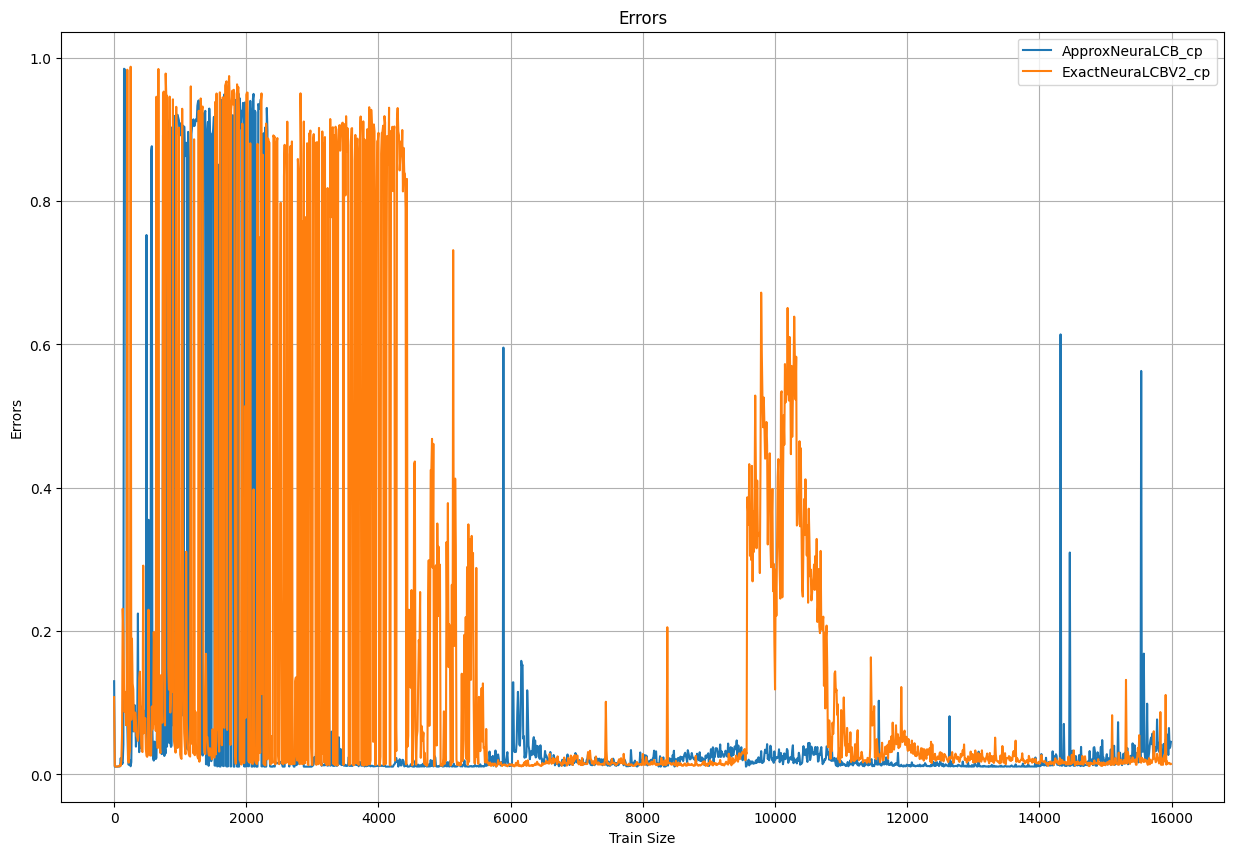

In [6]:
# def plot_sepsis_bmode():
# sepsis_path = './results/trainwins_50_testwins_5/sepsis_d=13_a=2_pi=eps-greedy0.1_std=0.01'
# sepsis_path_cp = './results/trainwins_500_testwins_250/sepsis_d=13_a=2_pi=eps-greedy0.1_std=0.01'

# approx_neural_path_cp = 'approx-neural-gridsearch_epochs=100_m=100_layern=True_buffer=-1_bs=32_lr=0.001_beta=0.1_lambda=0.0001_lambda0=0.1.npz'
# data_cp= np.load(os.path.join(sepsis_path_cp,approx_neural_path_cp)) 
import pandas as pd

# cp_experts = ['ApproxNeuraLCB_cp', 'ExactNeuraLCBV2_cp', 'NeuralGreedyV2_cp', 'ApproxNeuralLinLCBV2_cp', 'ExactNeuralLinLCBV2_cp']
# experts = ['NeuralGreedyV2_cp', 'ApproxNeuralLinLCBV2_cp', 'ApproxNeuralLinLCBJointModel_cp']
# nocp_experts = ['NeuralGreedyV2', 'ApproxNeuralLinLCBV2', 'ApproxNeuralLinLCBJointModel','ApproxNeuraLCBV2']
# experts = ['NeuralGreedyV2_cp', 'NeuralGreedyV2']
experts = ['ApproxNeuraLCB_cp', 'ApproxNeuraLCBV2']
experts = ['ApproxNeuraLCB_cp', 'ExactNeuraLCBV2_cp']
B= 10
# experts = ['ApproxNeuralLinLCBV2','ApproxNeuralLinLCBV2_cp' ]
# experts = ['ApproxNeuralLinLCBJointModel','ApproxNeuralLinLCBJointModel_cp']
# experts = ['NeuralGreedyV2',  'ApproxNeuralLinLCBJointModel','ApproxNeuraLCBV2','ApproxNeuraLCB_cp']
width = 15
height = 10
num_split = 1
len2plot = 1600
plt.figure(figsize = (width,height))
for algo_group in experts:
    if 'cp'in algo_group.split('_'):
        algo_prefix = f'{algo_group}-gridsearch_epochs={num_steps}_m={min(layer_sizes)}_layern={layer_n}_buffer={buffer_s}_bs={batch_size}_lr={lr}_beta={beta}_lambda={lambd}_lambda0={lambd0}_B={B}.csv' 
    else:
        algo_prefix = f'{algo_group}-gridsearch_epochs={num_steps}_m={min(layer_sizes)}_layern={layer_n}_buffer={buffer_s}_bs={batch_size}_lr={lr}_beta={beta}_lambda={lambd}_lambda0={lambd0}.csv' 
 
    sepsis_path_cp = os.path.join(res_dir, algo_prefix)   
    data_cp = pd.read_csv(sepsis_path_cp)
    # len2plot = int(len(data_cp)/num_split)
    regrets_cp = data_cp['regrets'][0:len2plot]
    # errs_cp = data_cp['act_errs'][0:len2plot]
    train_size = data_cp['train_size'][0:len2plot]
    print("Regrets_cp shape:", regrets_cp.shape)
    # print("Errors_cp shape:", errs_cp.shape)
    plt.plot(train_size, regrets_cp, label=f'{algo_group}')
plt.title('Regrets')
plt.xlabel('Train Size')
plt.ylabel('Regrets')
plt.legend()
plt.grid(True)
plt.show()

# Plot all errors in one figure
plt.figure(figsize=(width, height))
for algo_group in experts:
    if 'cp'in algo_group.split('_'):
        algo_prefix = f'{algo_group}-gridsearch_epochs={num_steps}_m={min(layer_sizes)}_layern={layer_n}_buffer={buffer_s}_bs={batch_size}_lr={lr}_beta={beta}_lambda={lambd}_lambda0={lambd0}_B={B}.csv' 
    else:
        algo_prefix = f'{algo_group}-gridsearch_epochs={num_steps}_m={min(layer_sizes)}_layern={layer_n}_buffer={buffer_s}_bs={batch_size}_lr={lr}_beta={beta}_lambda={lambd}_lambda0={lambd0}.csv' 
 
    
    sepsis_path_cp = os.path.join(res_dir, algo_prefix)   

    data_cp = pd.read_csv(sepsis_path_cp)
    # len2plot = int(len(data_cp)/4)
    errs_cp = data_cp['act_errs'][0:len2plot]
    train_size = data_cp['train_size'][0:len2plot]

    plt.plot(train_size, errs_cp, label=f'{algo_group}')
    
plt.title('Errors')
plt.xlabel('Train Size')
plt.ylabel('Errors')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# def plot_realworld_experiment(name, trainconfig, beta, rbf_sigma, lr=0.001, figshow=False, legendloc=None, save=True, tick_spacing=200, test_freq=10, policy='eps-greedy'):
#     res_dir = os.path.join('results', name)
#     approx_neural = 'approx-neural-gridsearch_epochs={}_m=100_layern=True_buffer={}_bs={}_lr={}_beta={}_lambda=0.0001_lambda0=0.1.npz'.format(trainconfig[0],trainconfig[1],trainconfig[2],lr,beta)
#     neural_greedy = 'neural-greedy-gridsearch_epochs={}_m=100_layern=True_buffer={}_bs={}_lr={}_lambda=0.0001.npz'.format(trainconfig[0],trainconfig[1],trainconfig[2],lr)
#     baseline = 'baseline_epochs=100_m=100_layern=True_beta=0.1_lambda0=0.1_rbf-sigma=1.0_maxnum=1000.npz'
#     kern = 'kern-gridsearch_beta=0.1_rbf-sigma={}_maxnum=1000.npz'.format(rbf_sigma)

#     neuralcb = np.load(os.path.join(res_dir,approx_neural))['arr_0']
#     neuralgreedy = np.load(os.path.join(res_dir,neural_greedy))['arr_0']
#     bl = np.load(os.path.join(res_dir,baseline))['arr_0']
#     kernlcb = np.load(os.path.join(res_dir,kern))['arr_0']

#     # Read data 
#     arrs = (neuralcb, neuralgreedy, bl, kernlcb) 
#     algos = ['NeuraLCB', 'NeuralGreedy', 'LinLCB', 'NeuralLinLCB', 'NeuralLinGreedy', 'KernLCB']
#     algos = ['NeuraLCB', 'NeuralGreedy', 'LinLCB', 'NeuralLinLCB', 'NeuralLinGreedy', 'KernLCB']
#     regrets = [] 
#     i = 0
#     for a in arrs:
#         for i in range(1,a.shape[1]):
#             regrets.append(a[:,i,:])

#     # Plot
#     filename = '{}_{}_cf={}{}{}_beta={}_lr={}_rbfsigma={}.pdf'.format(policy,name.split('_')[0],trainconfig[0],trainconfig[1],trainconfig[2],beta,lr,rbf_sigma)
#     print(filename)
#     plot(algos, regrets, cumsum=False, filename=filename if save else None, figshow=figshow, legendloc=legendloc, tick_spacing=tick_spacing, test_freq=test_freq)

## Plot everything

In [8]:
# policy = 'online'
# data_types = [
#              #'mushroom_d=117_a=2_pi={}0.1_std=0'.format(policy),
#               'statlog_d=10_a=7_pi={}0.1_std=0'.format(policy),
#               #'stock_d=21_a=8_pi=eps-greedy0.1_std=0.1',
#               #'jester_d=32_a=8_pi=eps-greedy0.1_std=0.1', 
#               #'covertype_d=54_a=7_pi=eps-greedy0.1_std=0', 
#               #'census_d=387_a=9_pi=eps-greedy0.1_std=0.0',
#               'adult_d=92_a=14_pi={}0.1_std=0.0'.format(policy),
#             'mnist_d=784_a=10_pi={}0.1_std=0'.format(policy)    
#             ]

# betas = [0.01,0.05,1.0,5.0, 10.0]
# trconfigs =  [(1,1,1),(100,-1,50)]
# rbf_sigmas = [0.1,1.0,10.0]
# lrs = [0.001,0.0001]
# for data_type in data_types:
#     if data_type.split('_')[0] == 'mnist':
#         test_freq = 100 
#         tick_spacing = 20 
#     else:
#         test_freq = 10 
#         tick_spacing = 200
#     for trconfig in trconfigs:
#         for beta in betas:
#             for lr in lrs:
#                 for rbf_sigma in rbf_sigmas:
#                     try:
#                         plot_realworld_experiment(data_type, trconfig, beta, rbf_sigma, lr, tick_spacing=tick_spacing,test_freq=test_freq, policy=policy)
#                     except: 
#                         fname =  'online_{}_cf={}{}{}_beta={}_lr={}_rbfsigma={}.pdf'.format(data_type.split('_')[0],trconfig[0],trconfig[1],trconfig[2],beta,lr,rbf_sigma)
#                         print('Not found {}'.format(fname))

## Plot S-mode vs B-mode 

In [9]:
# def plot_smode_vs_bmode(name, beta, lr=0.001, figshow=False, legendloc=None, save=True, tick_spacing=200, test_freq=10, policy='eps-greedy'):
#     res_dir = os.path.join('results', name)
#     smode = (1,1,1)
#     bmode = (100,-1,50)
#     approx_neural_smode = 'approx-neural-gridsearch_epochs={}_m=100_layern=True_buffer={}_bs={}_lr={}_beta={}_lambda=0.0001_lambda0=0.1.npz'.format(smode[0],smode[1],smode[2],lr,beta)    
#     approx_neural_bmode = 'approx-neural-gridsearch_epochs={}_m=100_layern=True_buffer={}_bs={}_lr={}_beta={}_lambda=0.0001_lambda0=0.1.npz'.format(bmode[0],bmode[1],bmode[2],lr,beta)
    
#     neural_greedy_smode = 'neural-greedy-gridsearch_epochs={}_m=100_layern=True_buffer={}_bs={}_lr={}_lambda=0.0001.npz'.format(smode[0],smode[1],smode[2],lr)
#     neural_greedy_bmode = 'neural-greedy-gridsearch_epochs={}_m=100_layern=True_buffer={}_bs={}_lr={}_lambda=0.0001.npz'.format(bmode[0],bmode[1],bmode[2],lr)


#     neuralcb_s = np.load(os.path.join(res_dir,approx_neural_smode))['arr_0']
#     neuralcb_b = np.load(os.path.join(res_dir,approx_neural_bmode))['arr_0']
    
    
#     neuralgreedy_s = np.load(os.path.join(res_dir,neural_greedy_smode))['arr_0']
#     neuralgreedy_b = np.load(os.path.join(res_dir,neural_greedy_bmode))['arr_0']


#     # Read data 
#     arrs = (neuralcb_s, neuralcb_b, neuralgreedy_s, neuralgreedy_b)
#     algos = ['NeuraLCB(S-mode)', 'NeuraLCB(B-mode)', 'NeuralGreedy(S-mode)', 'NeuralGreedy(B-mode)']
#     regrets = [] 
#     i = 0
#     for a in arrs:
#         for i in range(1,a.shape[1]):
#             regrets.append(a[:,i,:])

#     # Plot
#     filename = 'mode_{}_beta={}_lr={}_policy={}.pdf'.format(name.split('_')[0],beta,lr, policy)
#     print(filename)
#     plot(algos, regrets, cumsum=False, filename=filename if save else None, figshow=figshow, legendloc=legendloc, tick_spacing=tick_spacing, test_freq=test_freq)

In [10]:
# data_types = [
#             #  'mushroom_d=117_a=2_pi=eps-greedy0.1_std=0',
#             #   'statlog_d=10_a=7_pi=eps-greedy0.1_std=0',
              
#               'sepsis_d=13_a=2_pi=eps-greedy0.1_std=0.01'
              

#               #'stock_d=21_a=8_pi=eps-greedy0.1_std=0.1',
#               #'jester_d=32_a=8_pi=eps-greedy0.1_std=0.1', 
#               #'covertype_d=54_a=7_pi=eps-greedy0.1_std=0', 
#               #'census_d=387_a=9_pi=eps-greedy0.1_std=0.0',
# #               'adult_d=92_a=14_pi=eps-greedy0.1_std=0.0',
# #             'mnist_d=784_a=10_pi=eps-greedy0.1_std=0'    
#             ]
# policy='eps-greedy'
# test_freq = 10 # for mnist
# tick_spacing = 200  # mnist, 200 for other data
# betas = [0.01,0.05,1.0,5.0, 10.0]
# # lrs = [0.001,0.0001]
# lrs = [0.0001]
# for data_type in data_types:
#     if data_type.split('_') == 'mnist':
#         test_freq = 100 
#         tick_spacing=20
#     for beta in betas:
#         for lr in lrs:
#             #try:
#             plot_smode_vs_bmode(data_type, beta, lr, tick_spacing=tick_spacing,test_freq=test_freq,policy=policy)
#             #except: 
#             #    fname =  '{}_beta={}_lr={}.pdf'.format(data_type.split('_')[0],beta,lr)
#             #    print('Not found {}'.format(fname))